## COAST Transect Calculations
Exercise for calcualting temperature, velocities and transport along a transect.

#### Scripting - set paths and import modules
Begin with module imports.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import coast
import matplotlib.pyplot as plt

/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#ke

Set model paths

In [4]:
path = "/gws/nopw/j04/jmmp/tmp_slwa/AMM7_SSB_sample/"
path = "/gws/pw/j07/workshop/users/train006/AMM7_SSB_sample/"
model_path_t = path +  "amm7_1d_20070101_20070131_grid_T.nc"
model_path_u = path +  "amm7_1d_20070101_20070131_grid_U.nc"
model_path_v = path +  "amm7_1d_20070101_20070131_grid_V.nc"
jmmp_path = "/gws/nopw/j04/jmmp/"
domcfg_path = path + "amm7_SSB_mesh_mask.nc"

Set coast config paths

In [5]:
cfg_path = "/home/users/train006/CLASS_workshop/Analysis/AMM/COAST_CFG/"
nemo_t_json = cfg_path + "example_nemo_grid_t.json"
nemo_u_json = cfg_path + "example_nemo_grid_u.json"
nemo_v_json = cfg_path + "example_nemo_grid_v.json"
nemo_f_json = cfg_path + "example_nemo_grid_v.json"

Assign NEMO output to Gridded object to each position on the Awarkara C-Grid. These consist of:

- T-Grid for tracer points at the cell centres
- U-Grid for velocity points on the western cell edge
- V-Grid for velocity points on the southern cell edge
- F-Grid for vorticity/Coriolis points on the south-western cell corners

In [6]:
nemo_t = coast.Gridded(model_path_t, domcfg_path, config=nemo_t_json)
nemo_u = coast.Gridded(model_path_u, domcfg_path, config=nemo_u_json)
nemo_v = coast.Gridded(model_path_v, domcfg_path, config=nemo_v_json)
nemo_f = coast.Gridded(fn_domain=domcfg_path, config=nemo_f_json)

FileNotFoundError: [Errno 2] No such file or directory: '/gws/pw/j07/workshop/users/train006/AMM7_SSB_sample/amm7_1d_20070101_20070131_grid_U.nc'

Get transects at T and F points.

In [10]:
tran_t = coast.TransectT(nemo_t, (54, -15), (56, -12))
tran_f = coast.TransectF(nemo_f, (54, -15), (56, -12))

Add velociites normal to to transect.

In [11]:
tran_f.calc_flow_across_transect(nemo_u, nemo_v)

### Plotting

#### Plot Time-Mean Temperature Along Extracted Transect

Alias temperature variable.

In [12]:
temp = tran_t.data.temperature

Take time-mean of temperature transect.

In [13]:
temp_mean = temp.mean(dim="t_dim")

Plot time-mean temperature along transect.

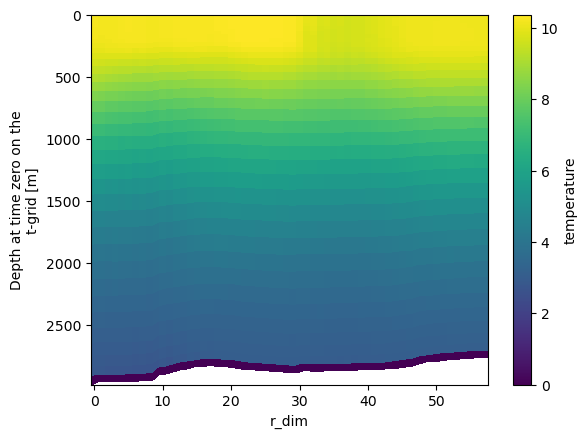

In [14]:
temp_mean.plot.pcolormesh(y="depth_0", yincrease=False)

#### Plot Time-Mean velocities normal to the transect

Alias normal velocites.

In [15]:
cross_vel = tran_f.data_cross_tran_flow.normal_velocities

Take time-mean of velocity transect.

In [16]:
cross_vel_mean = cross_vel.mean(dim="t_dim")

Plot time-mean cross transect velocities

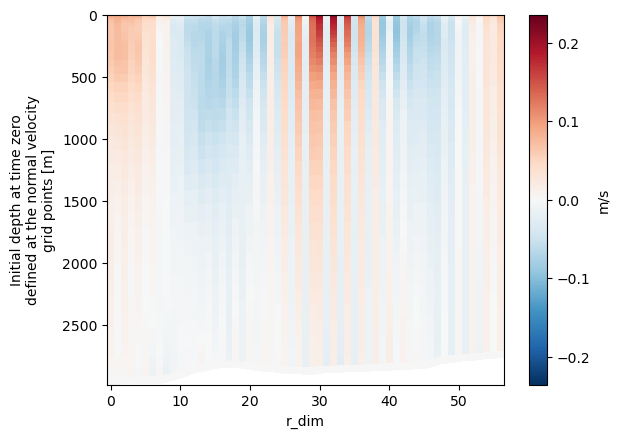

In [17]:
cross_vel_mean.plot.pcolormesh(yincrease=False, y="depth_0", cbar_kwargs={"label": "m/s"})

#### Plot Time-Mean Volume Transport Accoss Transect

Alias transport normal to transect.

In [18]:
cross_transport = tran_f.data_cross_tran_flow.normal_transports

Take time mean.

In [19]:
cross_transport_mean = cross_transport.mean(dim="t_dim")

Plot cross transect transport.

Text(0, 0.5, 'Sv')

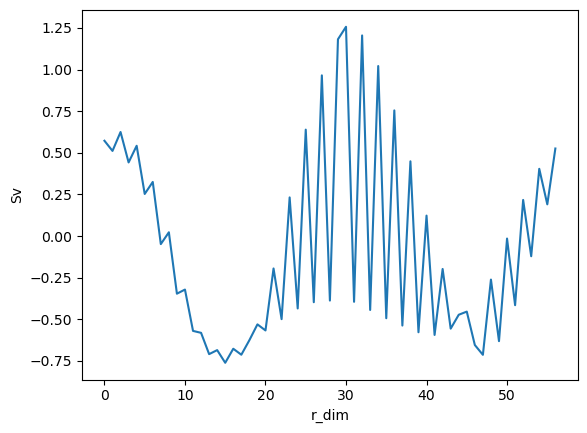

In [20]:
cross_transport_mean.plot()
plt.ylabel("Sv")

The above creates a noisy field due to a zig-zag path taken by the transect.

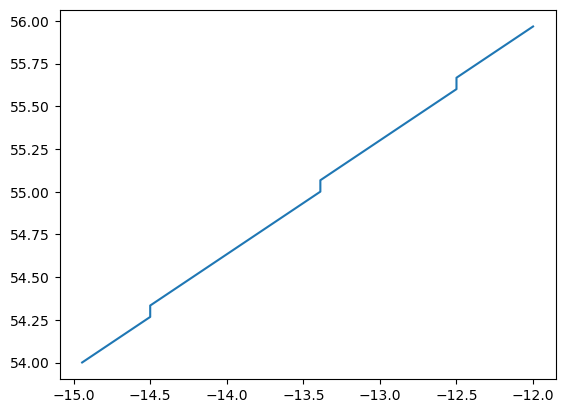

In [22]:
plt.plot(cross_transport_mean.longitude, cross_transport_mean.latitude)